# Class 2 - Shortcut Learning

The notebook is divided in 3 parts:

- in the first part you mostly follow the code, trying to grasp the idea by observing the mismatch in the results
- the second part is on you. Your task is to reproduce the results from the very important paper, which points out the simplicity bias in real world problems
- the third part is optional (very likely that we go back later this semester) and deals with potential solutions to our issue

# First part

## Introduction to the problem

Deep neural networks often solve problems by taking shortcuts instead of learning the
intended solution, leading to a lack of generalisation and unintuitive failures. This pattern can be
observed in many real-world applications

**Food for thought**: what is the equivalent issue in your area of expertise?

### References

https://arxiv.org/pdf/2004.07780.pdf

## Capture the problem

### From the paper

Reproduce *Fig 2*:
> During training, stars were always shown in the top right or bottom left of an image; moons in the top left or bottom right. 
This pattern is still present in samples from the i.i.d. test set (middle row) but not in o.o.d. test images (bottom row), exposing the shortcut.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.utils.data as utils
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import sys
from torchvision.utils import make_grid as make_grid
import requests
from io import BytesIO
import cv2
from resizeimage import resizeimage

### Data

In [4]:
bunny = np.load('../shortcut/bunny.npy')
cow = np.load('../shortcut/cow.npy')

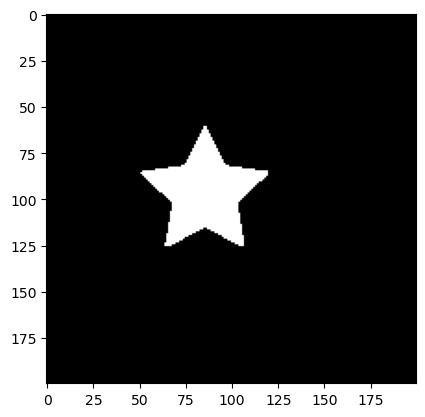

In [10]:
num_rows, num_cols = bunny.shape[:2]
# bottom right: 46 39 to 60 70
translation_matrix = np.float32([ [1,0,0], [0,1,0] ])
var = cow # bunny
img_translation = cv2.warpAffine(var, translation_matrix, (num_cols, num_rows))
plt.imshow(img_translation,cmap='gray')

In [11]:
biased_train_bun = []
biased_train_cow = []
unbiased_train_bun = []
unbiased_train_cow = []

In [12]:
for i in range(1000):
  
  x_val = np.random.randint(46,60)
  y_val = np.random.randint(39,70)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(bunny, translation_matrix, (200, 200))
  biased_train_bun.append(im)
  x_val = np.random.randint(-53,-39)
  y_val = np.random.randint(-65,-34)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(bunny, translation_matrix, (200, 200))
  biased_train_bun.append(im)
  
  y_val = np.random.randint(44,64)
  x_val = np.random.randint(-46,-22)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(cow, translation_matrix, (200, 200))
  biased_train_cow.append(im)
  y_val = np.random.randint(-56,-33)
  x_val = np.random.randint(55,78)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(cow, translation_matrix, (200, 200))
  biased_train_cow.append(im)
  

for i in range(2000):
  
  x_val = np.random.randint(-53,60)
  y_val = np.random.randint(-65,70)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(bunny, translation_matrix, (200, 200))
  unbiased_train_bun.append(im)
  
  y_val = np.random.randint(-56,64)
  x_val = np.random.randint(-46,78)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(cow, translation_matrix, (200, 200))
  unbiased_train_cow.append(im)

In [13]:
biased_train_cow = np.array(biased_train_cow)
biased_train_bun = np.array(biased_train_bun)
unbiased_train_cow = np.array(unbiased_train_cow)
unbiased_train_bun = np.array(unbiased_train_bun)

In [14]:
unbiased_squares = unbiased_train_cow
unbiased_hearts = unbiased_train_bun
biased_squares = biased_train_cow
biased_hearts = biased_train_bun

In [42]:
some_unbiased_squares = unbiased_squares[:25]
np.random.shuffle(some_unbiased_squares)
some_unbiased_hearts = unbiased_hearts[:25]
np.random.shuffle(some_unbiased_hearts)
some_biased_squares = biased_squares[:25]
np.random.shuffle(some_biased_squares)
some_biased_hearts = biased_hearts[:25]
np.random.shuffle(some_biased_hearts)

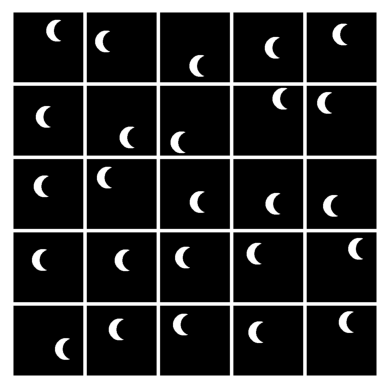

In [48]:
data_to_viz = "moons"
assert data_to_viz in ["stars", "moons"]
data_to_grid = some_unbiased_hearts if data_to_viz == "moons" else some_unbiased_squares
grid = make_grid(torch.from_numpy(np.float32(data_to_grid)).view(25,1,200,200),nrow=5,pad_value=1,padding=10)
plt.axis('off')
plt.imsave(f'../shortcut/unbiased_{data_to_viz}.png',grid.numpy().transpose(1,2,0))
plt.imshow(grid.numpy().transpose(1,2,0))

In [44]:
unbiased_data = np.concatenate((unbiased_squares,unbiased_hearts))
unbiased_data = torch.from_numpy(np.float32(unbiased_data))
labels = np.concatenate((np.zeros(len(unbiased_squares)),np.ones(len(unbiased_squares))))
labels = torch.from_numpy(labels).long()
biased_data = np.concatenate((biased_squares,biased_hearts))
biased_data = torch.from_numpy(np.float32(biased_data))

In [30]:
train_data = utils.TensorDataset(biased_data,labels) 
train_loader = utils.DataLoader(train_data,batch_size=100,shuffle=True) 
test_data = utils.TensorDataset(unbiased_data,labels) 
test_loader = utils.DataLoader(test_data,batch_size=100)

### Model

In [23]:
# Build FC net
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(200*200, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 2)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.c1 = nn.Conv2d(1, 32, 5, 1, padding=2)
        self.c2 = nn.Conv2d(32, 32, 5, 1, padding=2)
        self.c3 = nn.Conv2d(32, 32, 5, 1, padding=2)
        self.pool = nn.AvgPool2d(200)
        self.fc = nn.Linear(32, 2)
    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [24]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.c1 = nn.Conv2d(1, 128, 5,stride=2,padding=2)
        self.c2 = nn.Conv2d(128, 128, 5,stride=2,padding=2)
        self.c3 = nn.Conv2d(128, 128, 5,stride=2,padding=2)
        self.pool = nn.AvgPool2d(25)
        self.fc = nn.Linear(128, 2)
    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [25]:
net = Net()

In [26]:
lr = 0.001
bs = 100
epochs = 100
log_interval = 10

In [27]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# criterion = nn.MSELoss()     
criterion = nn.CrossEntropyLoss()

In [28]:
epochs = 5

for epoch in range(epochs):
    total = 0.
    correct = 0.
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        data = data.view(-1, 200*200)
        target = target.squeeze()
        optimizer.zero_grad()
        net_out = net(data).squeeze()
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data), len(train_loader.dataset),
                           100 * batch_idx / len(train_loader), loss.item()))
            
        _, predicted = torch.max(net_out.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print('Train Acc: '+str(correct/total))

Train Epoch: 1 [0/4000 (0%)]	Loss: 0.688216
Train Epoch: 1 [1000/4000 (25%)]	Loss: 0.000000
Train Epoch: 1 [2000/4000 (50%)]	Loss: 0.000000
Train Epoch: 1 [3000/4000 (75%)]	Loss: 0.000000
Train Epoch: 2 [0/4000 (0%)]	Loss: 0.000000
Train Epoch: 2 [1000/4000 (25%)]	Loss: 0.000000
Train Epoch: 2 [2000/4000 (50%)]	Loss: 0.000000
Train Epoch: 2 [3000/4000 (75%)]	Loss: 0.000000
Train Epoch: 3 [0/4000 (0%)]	Loss: 0.000000
Train Epoch: 3 [1000/4000 (25%)]	Loss: 0.000000
Train Epoch: 3 [2000/4000 (50%)]	Loss: 0.000000
Train Epoch: 3 [3000/4000 (75%)]	Loss: 0.000000
Train Epoch: 4 [0/4000 (0%)]	Loss: 0.000000
Train Epoch: 4 [1000/4000 (25%)]	Loss: 0.000000
Train Epoch: 4 [2000/4000 (50%)]	Loss: 0.000000
Train Epoch: 4 [3000/4000 (75%)]	Loss: 0.000000
Train Epoch: 5 [0/4000 (0%)]	Loss: 0.000000
Train Epoch: 5 [1000/4000 (25%)]	Loss: 0.000000
Train Epoch: 5 [2000/4000 (50%)]	Loss: 0.000000
Train Epoch: 5 [3000/4000 (75%)]	Loss: 0.000000
Train Acc: 1.0


In [29]:
total = 0.
correct = 0.
for idx, (data, target) in enumerate(test_loader):
  #data, target = Variable(data).cuda(), Variable(target).cuda()
  data, target = Variable(data), Variable(target)
  data = data.view(-1, 200*200)
  optimizer.zero_grad()
  net_out = net(data).squeeze()
  _, predicted = torch.max(net_out.data, 1)
  total += target.size(0)
  correct += (predicted == target).sum().item()
print('Test Acc: '+str(correct/total))

Test Acc: 0.5055


---

# Second Part

**Think over** Think again about your domain of expertize and the potential issues caused by shortcut learning

write some insights

### Real case study: hospital

https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002683

The prevalence of pneumonia was high enough at MSH (34.2%) relative to NIH and IU (1.2% and 1.0%) that merely sorting by hospital system achieved an AUC of 0.861 (95% CI 0.855–0.866) on the joint MSH–NIH dataset. Models trained on data from either NIH or MSH had equivalent performance on IU (P values 0.580 and 0.273, respectively) and inferior performance on data from each other relative to an internal test set (i.e., new data from within the hospital system used for training data; P values both <0.001)

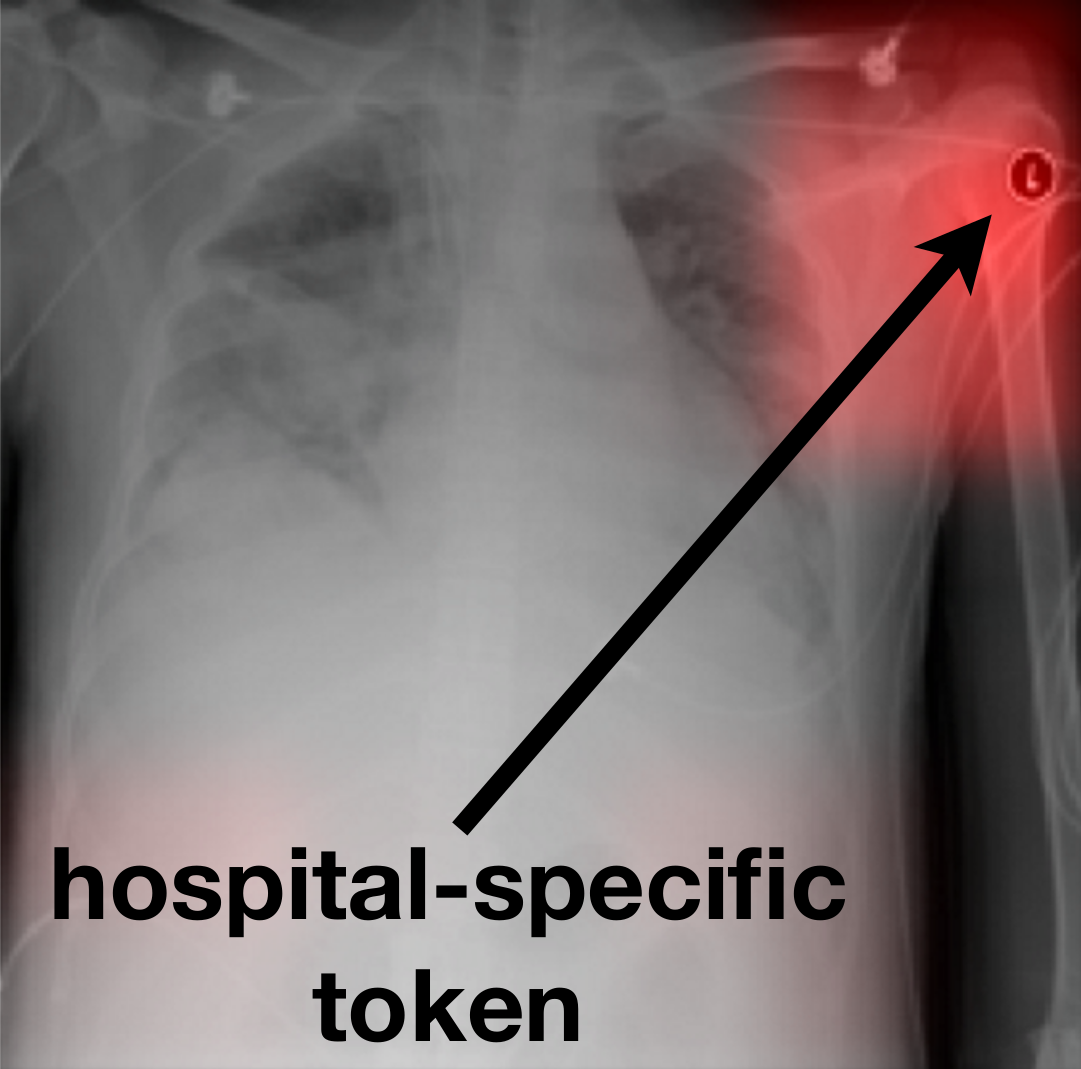

1. skim through the paper
2. load the data [MSH NIH]  
a. https://github.com/jrzech/cxr-generalize  
b. https://nihcc.app.box.com/v/ChestXray-NIHCC  
3. set up CNN model
4. help with activation maps
5. train
6. inspect AUC / Acc / Specificity

### Exercise


Get familiar with the built-in family of models in torchvision. https://pytorch.org/vision/0.9/models.html

Create two models, of the designed architecture (for instance densenet121).  
- the first one is randomly initialized  
- the second one is pre-trained on Imagenet-1k

Compare the performance

In [28]:
# write your code here


### Exercise


Implement AUC metric and validate your method against the following test

do not use https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

In [ ]:
# write your code here

In [20]:
def test_your_auc(func, eps = 0.005):
    """
    func is expected to take y and target y
    """
    
    import numpy as np
    from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
    import matplotlib.pyplot as plt
    
    n = 10000
    y = np.array([0] * n + [1] * n)
     
    #y_prob = np.array(
    #    np.random.uniform(.25, .5, n//2).tolist() + 
    #    np.random.uniform(.3, .7, n).tolist() +
    #    np.random.uniform(.5, .75, n//2).tolist()
    #)
    y_prob = np.array(
        np.random.uniform(0, .4, n//2).tolist() + 
        np.random.uniform(.3, .7, n).tolist() + 
        np.random.uniform(.6, 1, n//2).tolist()
    )

    your_val = func(y, y_prob)

    micro_roc_auc_ovr = roc_auc_score(
        y,
        y_prob,
        multi_class="ovr",
        average="micro",
    )

    return abs(your_val - micro_roc_auc_ovr)/micro_roc_auc_ovr < eps
    

## Another examples/resources of shortcut learning

https://thegradient.pub/shortcuts-neural-networks-love-to-cheat/

https://github.com/NinaWie/featout

Older patients: https://arxiv.org/pdf/2009.10132.pdf (with DenseNets on MIMIC-CXR and CheXpert datasets)

https://github.com/NeurAI-Lab/InBiaseD

---

# THIRD PART

Let X be the set of input data, Y the set of target attributes that we want the

model to learn, and B the set of bias attributes that are irrelevant to the targets.

Our goal is to learn a function f : X → Y that would not be affected by the dataset bias

paper https://arxiv.org/pdf/2203.09860.pdf & code from https://github.com/LLYXC/PBBL

### Our first observation is that bias-imbalanced training data leads to a biased classifier

In [ ]:
!pip install torchxrayvision

Follow their github repo. Either:

- clone and work on their code
- copy here the most important 
    - IdxDataset in data.util
    - get_model arch definition in util
    - train loop 239-296 in main.py
    - MultiDimAverageMeter metric

In [22]:
# write your code here

### Pseudo Bias Balanced Learning

Explore more https://github.com/i6092467/diff-bias-proxies

https://github.com/YyzHarry/shortcut-ood-fairness

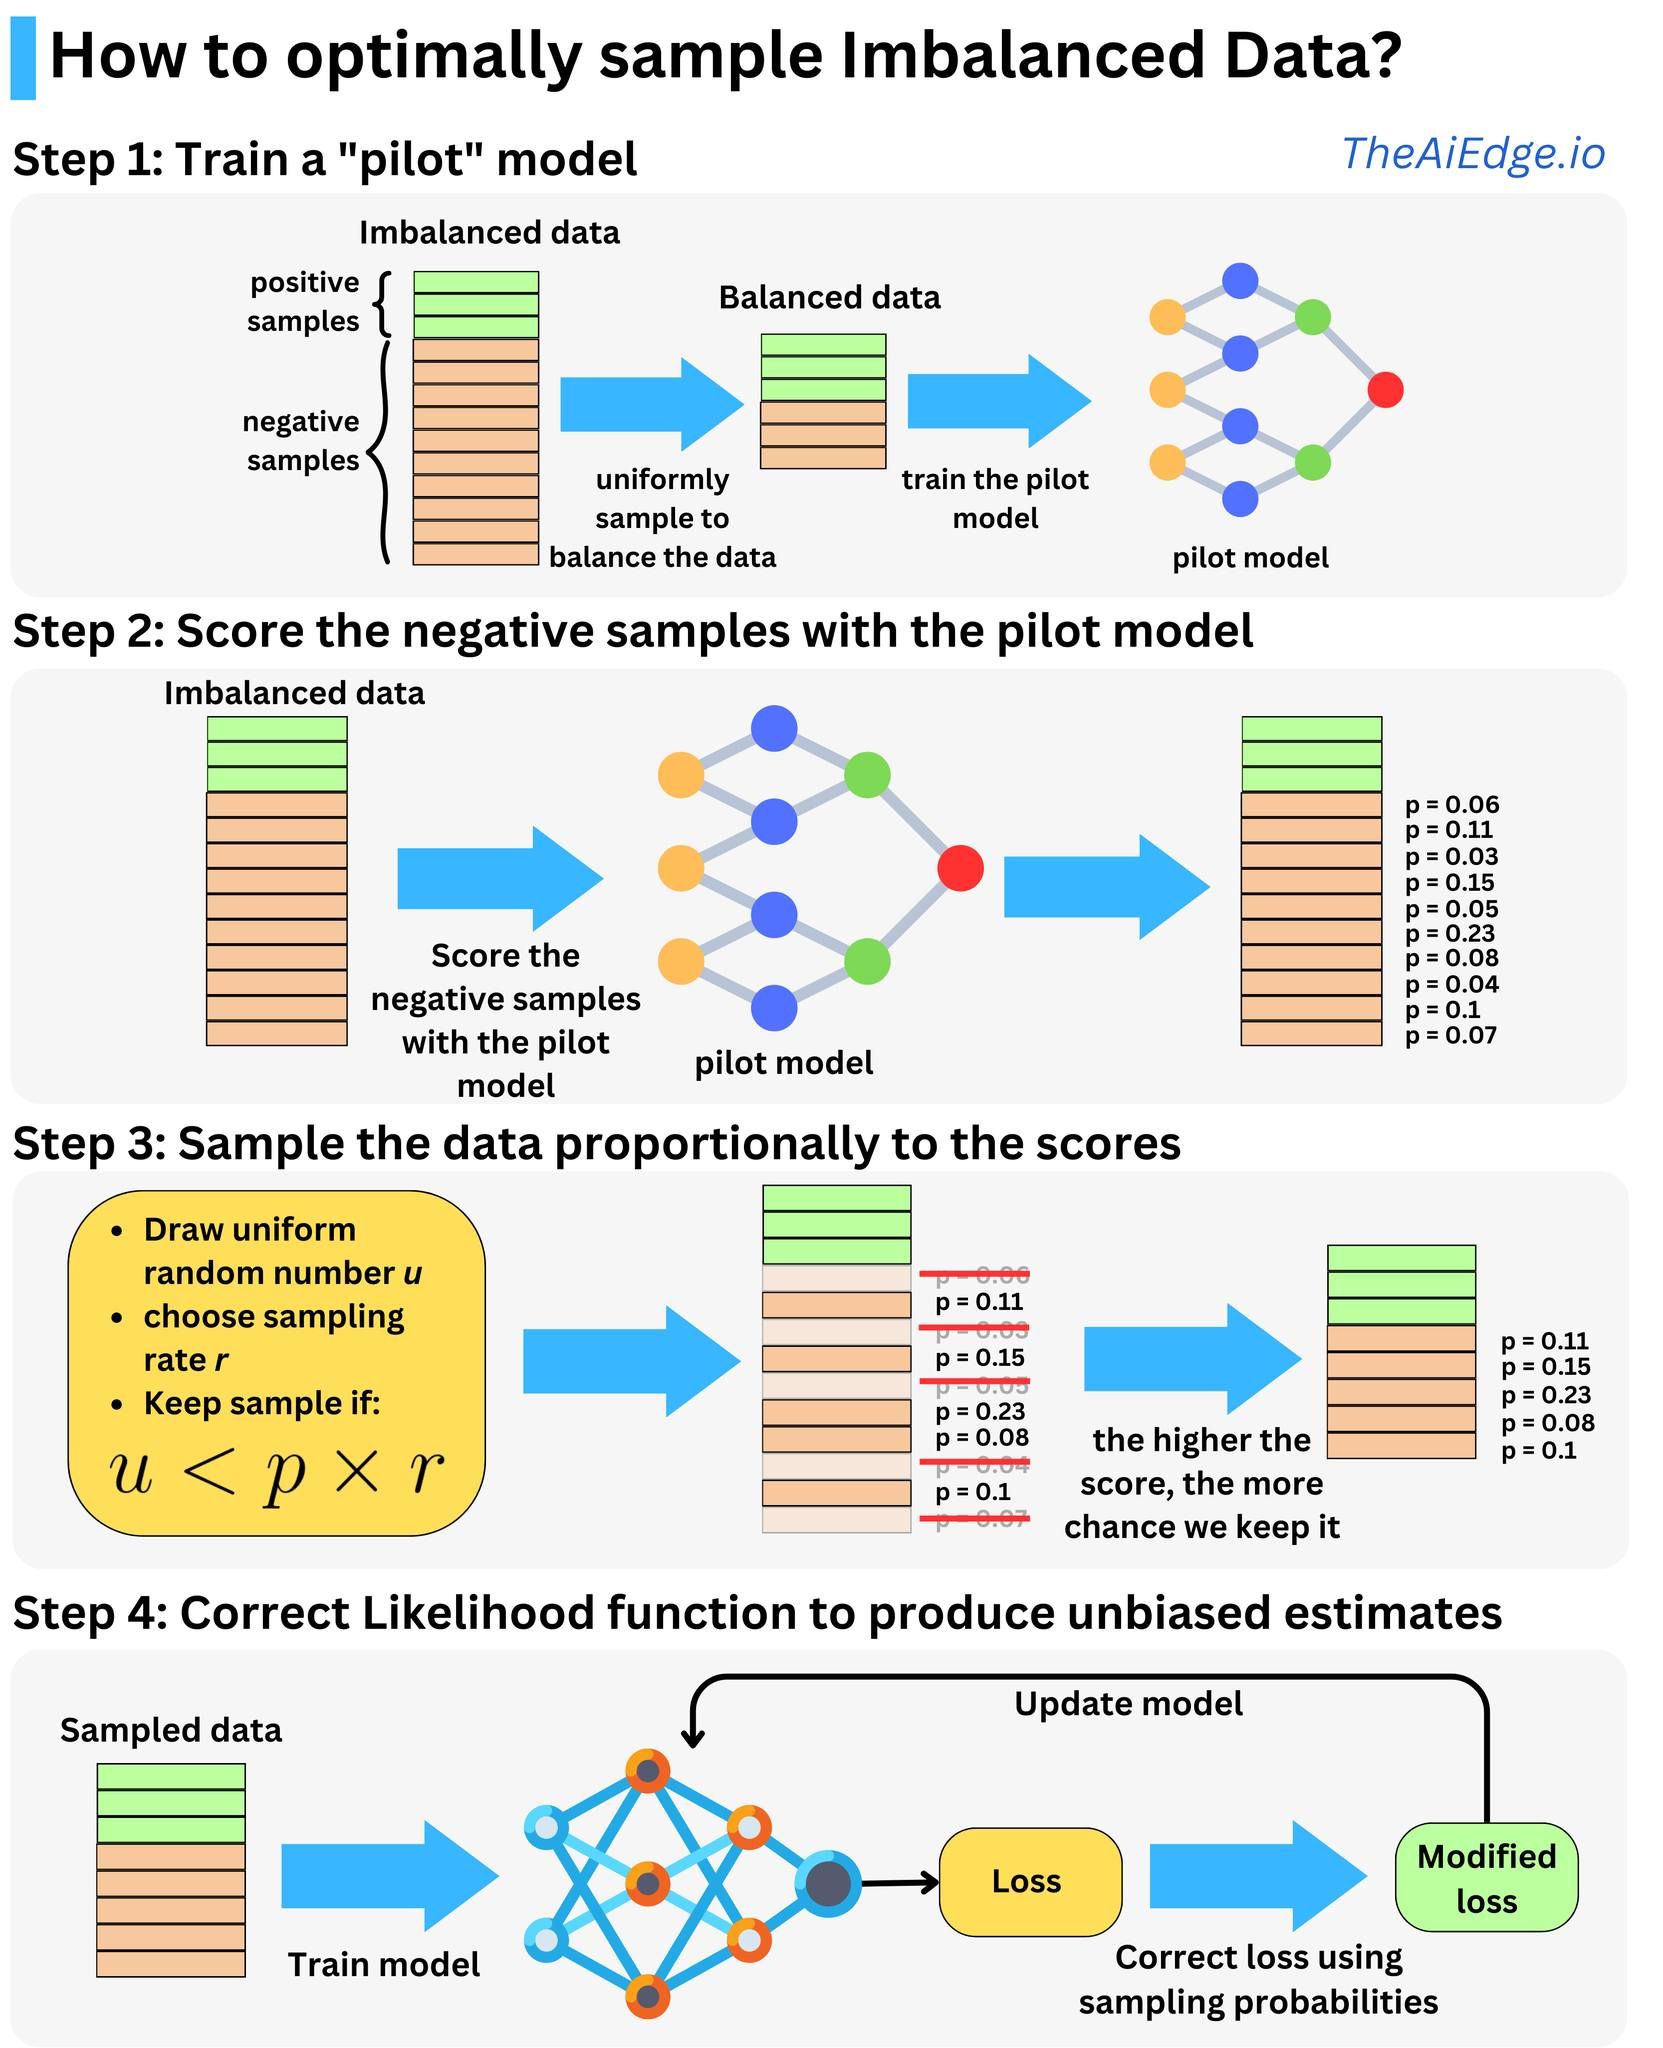

## Discover solutions

Think about potential solutions that may mitigate the effect of data imbalance / 

Just train twice! https://arxiv.org/abs/2107.09044

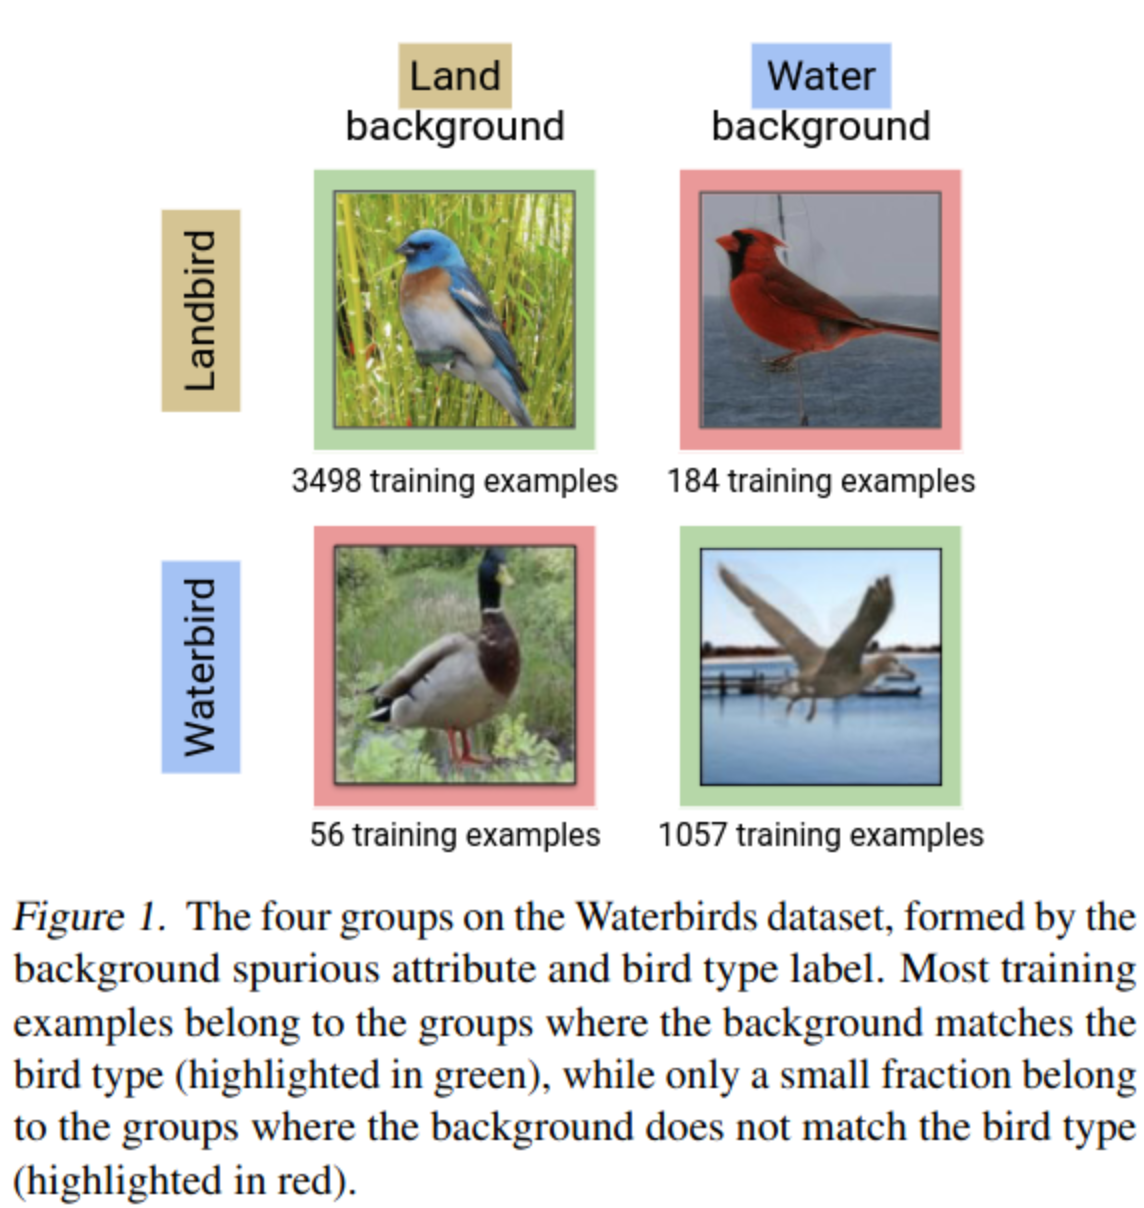

**Idea**: Instead of minimizing the expected loss over the empirical
training distribution, distributionally robust learning algo-
rithms define an uncertainty set over distributions that are
within some distance of the empirical training distribution, 
and then minimize the expected loss over the worst-case
distribution in this uncertainty set

**Solution**

$$ J_{CVaR} ( \theta, \alpha ) = \text{sup}_{q \in \Delta^n} \{ \sum_i^n \mathcal{l} (x_i, y_i; \theta) \text{s.t.} \| q \|_{\infty} \leq \frac{1}{\alpha n} \} $$

Note that the CVaR objective is equivalent to the average
loss incurred by the α-fraction of training points that have
the highest loss

In [25]:
# write modfied objective function with default hyperparameter $\alpha$ equal to 0.5

If you stuck, watch https://github.com/anniesch/jtt

In [23]:
# write your code here